The goal is to interpret the cryptomarket with the help of a 2D map & overlay network generated with affinity propagation, a better clustering technique compared to Kmeans clustering.

Clustering is an unsupervised learning tefchnique that aims to group similar objects into clusters while separating from different 
objects.Crypto being filled with real word data, prototype based clustering approaches are not the best approach given that the number of clusters is unknown and difficult to guess which is why we rely on affinity propagation an approach that automatically estimate the number of clusters. 

Affinity propagation identifies clusters by comparing data point with one another by measuring similarities, this approach selects cluster centers that represent other surrounding data points.

***
Make sure to have cmcScraper (pip install cryptocmd), pandas, NumPy, matplotlib & Seaborn installed

In [20]:
# pip install cryptocmd

STEPS:
1/ Defining a list of cryptocurrencies of interest and download their price data from coinmarketcap using cmcscraper
2/ Visualizing the historical price data for better understanding
3/ Preparing and cleaning the data before clustering
4/ Affinity propagation to cluster
5/ Calculating covariances matrixes between clusters
6/ Arranging cryptocurrencies on 2D map to create a network overlay based on covariance
7/ Interpreting the crypto market map

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import cluster, covariance, manifold
from cryptocmd import CmcScraper

#Define the coins of interest in a dictionary

symbols_dict = {
    'BTC':'Bitcoin',
    'ETH': 'Ethereum',
    'XRP': 'Ripple',
    'ADA': 'Cardano',
    'KMD': 'Komodo',
    'BNB': 'Binance Coin',
    'DOGE': 'Doge Coin',
    'LTC': 'Litecoin',
    'USDT': 'Tether',
    'ZRX': 'Zer0',
    'BAT': 'Battoken',
    'UNI': 'DOT',
    'PSG': 'PSG Token',
    'ACM': 'ACM Token',
    'RSR': 'AS Roma Token',
    'JUV': 'Juventus Token',
    'ATM': 'Atletico Madrid Token',
    'SOL': 'Solana',
    'MATIC': 'Polygon',
    'LINK': 'Link',
    'ETC': 'Ethereum Classic', 
    'AVAX': 'Avalanche', 
    'DCR': 'Decred',
    'WAVES': 'WAVES',
    'VET' : 'Vechain', 
    'ARK' : 'ARK',
    'BCH': 'Bitcoin Cash', 
    'ICP': 'Internet Computer', 
    'DGB': 'DigiByte',
    'BTT': 'Bittorrent',
    'CEL': 'Celsius',
    'SNX': 'Synthetix', 
    'ENJ': 'Enjin',
    'ZIL': 'Ziliqa',
    'CHZ': 'Chiliz', 
    'THETA': 'Theta',
    'XLM': 'Stellar Lumen', 
    'SYS': 'Sys Coin',
    'LRC': 'Loopring',
    'EOS': 'EOS', 
    'NEO': 'NEO',
    'XRM': 'Monero',
    'DUSK': 'Dusk',
    'ALGO': 'Algo',
    'RAY': 'RAY',
    'DYDX': 'DYDX',
    'ENS':'ENS',
    'GMT':'GMT',
    'DGB': 'Digibyte',
    'ZLQ': 'Ziliqa'
}

def load_fresh_data_and_save(symbols_dict, save_path):
    symbols, names = np.array(sorted(symbols_dict.items())).T
    for symbol in symbols:

        #Scraper initialization
        scraper = CmcScraper(symbol)

        df_coin_prices = scraper.get_dataframe()
        df = pd.DataFrame()
        print(f'Fetching prices for {symbol}')

        df[symbol + '_Open'] = df_coin_prices['Open']
        df[symbol + '_Close'] = df_coin_prices['Close']
        df[symbol + '_Avg'] = (df_coin_prices['Close'] + df_coin_prices['Open']) / 2

        df[symbol + '_p'] = (df_coin_prices['Open'] - df_coin_prices['Close']) / df_coin_prices['Open']

        if symbol == symbols[0]:
            df_crypto = df.copy()
        else:
            df_crypto = pd.merge(
                left = df_crypto, right = df , how = "outer",
                left_index = True, right_index = True)

        filter_columns = [s for s in df_crypto.columns if '_p' in s]
        X_df_filtered = df_crypto[filter_columns].copy()
    X_df_filtered.to_csv(save_path + 'historical_crypto_prices.csv')
    return names, symbols, X_df_filtered
save_path = ''


#When the next line is set to False the data will only be downloaded when code is executed

new_data = True
if new_data == False:
    try:
        print('Loading From Local Disk')
        X_df_filtered = pd.read_csv(save_path + 'historical_crypto_prices.csv')
        if 'Unnamed: 0' in X_df_filtered.columns:
            X_df_filtered = X_df_filtered.drop(['Unnamed: 0'], axis = 1)
            symbols, names = np.array(sorted(symbols_dict.items())).T
        print(list(X_df_filtered.columns))
    except:
        print("No existing price data found - loading fresh data from CMC and saving to disk!")
        names, symbols, X_df_filtered = load_fresh_data_and_save(symbols_dict, save_path)
else:
        print("Loading fresh data from CMC and saving to disk")
        names, symbols, X_df_filtered = load_fresh_data_and_save(symbols_dict, save_path)
        print(list(symbols))
t = 100
X_df_filtered = X_df_filtered[:t]
X_df_filtered.head()

Loading fresh data from CMC and saving to disk
Fetching prices for ACM
Fetching prices for ADA
Fetching prices for ALGO
Fetching prices for ARK
Fetching prices for ATM
Fetching prices for AVAX
Fetching prices for BAT
Fetching prices for BCH
Fetching prices for BNB
Fetching prices for BTC
Fetching prices for BTT
Fetching prices for CEL
Fetching prices for CHZ
Fetching prices for DCR
Fetching prices for DGB
Fetching prices for DOGE
Fetching prices for DUSK
Fetching prices for DYDX
Fetching prices for ENJ
Fetching prices for ENS
Fetching prices for EOS
Fetching prices for ETC
Fetching prices for ETH
Fetching prices for GMT
Fetching prices for ICP
Fetching prices for JUV
Fetching prices for KMD
Fetching prices for LINK
Fetching prices for LRC
Fetching prices for LTC
Fetching prices for MATIC
Fetching prices for NEO
Fetching prices for PSG
Fetching prices for RAY
Fetching prices for RSR
Fetching prices for SNX
Fetching prices for SOL
Fetching prices for SYS
Fetching prices for THETA
Fetchin

,ACM_p,ADA_p,ALGO_p,ARK_p,ATM_p,AVAX_p,BAT_p,BCH_p,BNB_p,BTC_p,...,THETA_p,UNI_p,USDT_p,VET_p,WAVES_p,XLM_p,XRM_p,XRP_p,ZIL_p,ZRX_p
0,0.020506,0.009741,-0.098832,0.031311,0.021159,0.035297,0.012392,0.008263,-0.001446,0.014553,...,0.031331,-0.036080,0.000008,0.012235,-0.027051,-0.000210,0.0,-0.006242,-0.033801,0.020149
1,0.073755,0.118062,0.112314,0.061526,0.097666,0.118503,0.101386,0.074992,0.058866,0.078613,...,0.114895,0.077865,0.000050,0.116774,0.112127,0.072077,0.0,0.073596,0.159432,0.103167
2,-0.067008,-0.163188,-0.066797,-0.091557,-0.089164,-0.124505,-0.127104,-0.072922,-0.049596,-0.051668,...,-0.125721,-0.161288,-0.000017,-0.150534,-0.294603,-0.072630,0.0,-0.068897,-0.383730,-0.149752
3,0.054852,0.013162,-0.087367,0.013165,0.019530,0.013452,0.013241,0.019722,0.015805,0.020184,...,0.001925,0.011817,-0.000094,0.014308,0.040915,0.009169,0.0,0.015253,0.030132,0.032413
4,0.007013,0.011072,-0.023333,0.010107,0.006464,-0.028279,0.027664,-0.002467,0.001513,-0.001485,...,0.018402,0.026534,0.000145,0.020857,0.058896,0.012777,0.0,-0.010611,0.048177,-0.003513


Data Visualization, line graphs.

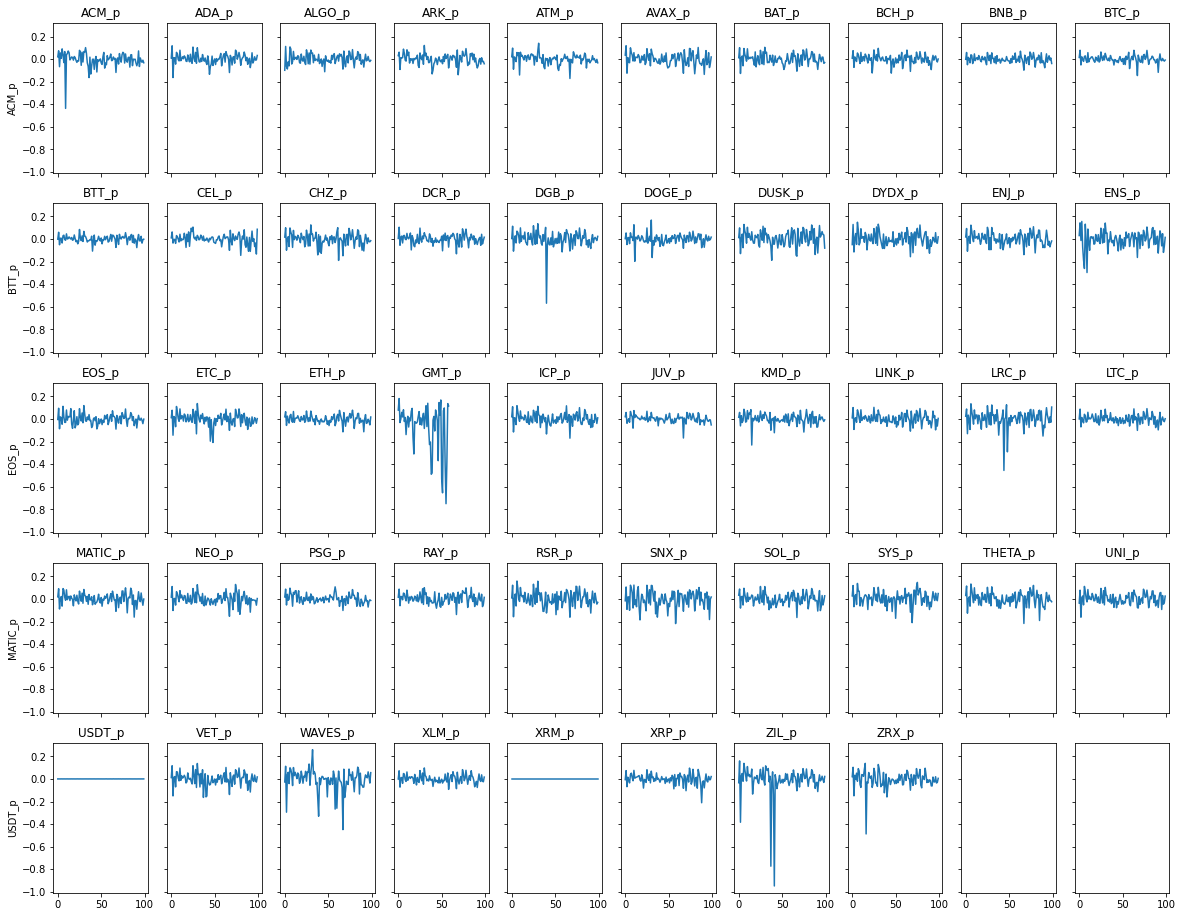

In [26]:
list_length = X_df_filtered.shape[1]
ncols = 10
nrows = int(round(list_length / ncols, 0))
height = list_length / 3 if list_length > 30 else 4

fig, axs = plt.subplots(nrows = nrows , ncols = ncols, sharex = True, sharey = True, figsize =(20, height))
for i, ax in enumerate(fig.axes):
    if i < list_length:
        sns.lineplot(data = X_df_filtered, x = X_df_filtered.index, y = X_df_filtered.iloc[:, i], ax = ax)
        ax.set_title(X_df_filtered.columns[i])
plt.show()